# Load libraries, define constants, functions, and classes

* libraries

In [1]:
import sys
sys.path.append("../../2_train_and_test_models")

import random
random.seed(1234)

import os
import matplotlib.tri as tri
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

from params import ROOT, GENOMES, TFS, SPECIES, Params
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score

* constants

In [2]:
# Shorthand names for all model types to include in plots
MODELS = [
    "BM",
    "GRL",
    "MORALE"
]

# Plot-acceptable names for model types
MODEL_NAMES = {
    "BM-mm10": "Mouse-trained",
    "BM-hg38": "Human-trained",
    "GRL-mm10": "Mouse-trained (+GRL)",
    "GRL-hg38": "Human-trained (+GRL)",
    "MORALE-mm10": "Mouse-trained (+MORALE)",
    "MORALE-hg38": "Human-trained (+MORALE)"
}

# Constants to be used for plot appearance details
DOT_SIZE = 5

ALPHA = 0.03
AXIS_SIZE = 11
AX_OFFSET = 0.02
TF_TWINAX_OFFSET = 0.35
FIG_SIZE_UNIT = 5
FIG_SIZE_2_by_4 = (FIG_SIZE_UNIT, FIG_SIZE_UNIT * 2)
FIG_SIZE_1_by_2 = (FIG_SIZE_UNIT / 2, FIG_SIZE_UNIT)
BOUND_SUBSAMPLE_RATE = 4

# If you don't care about plotting all examples
# and want to speed things up, you can set SKIP to not None;
# every SKIP-th ***UNBOUND*** example will be used in model evaluation.
# Note that since bound sites are so sparse, SKIP only applies
# to UNBOUND sites.
SKIP = 200

SPECIES1 = "hg38"
SPECIES2 = "mm10"

# Load functions for plotting

In [3]:
def get_preds_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.preds.npy"

def get_labels_file(model, tf, source_species, domain):
    preds_root = f"{ROOT}/output"
    os.makedirs(preds_root, exist_ok=True)
    return f"{preds_root}/{model}_tf-{tf}_trained-{source_species}_tested-{domain}.labels.npy"

def load_fivefold_data(average=False, verbose=False):
    preds_dict      = defaultdict(lambda : defaultdict(lambda : dict()))
    labels_dict     = defaultdict(lambda : defaultdict(lambda : dict()))
    bound_indices   = defaultdict(lambda : defaultdict(lambda : dict()))
    unbound_indices = defaultdict(lambda : defaultdict(lambda : dict()))

    # Loop over mouse-trained, human-trained models, and domain-adaptive models
    for model in MODELS:
        for tf in TFS:
            for source in SPECIES:
                for target in SPECIES:
                    if verbose:
                        print(f"\t({model} on {tf} when: {source}-trained, and {target}-tested)")
                        
                    preds_file  = get_preds_file(model=model, tf=tf, source_species=source, domain=target)
                    labels_file = get_labels_file(model=model, tf=tf, source_species=source, domain=target)
                
                    try:
                        # Load them
                        preds = np.load(preds_file)
                        labels = np.load(labels_file)

                        # Calculate if we need to truncate the labels
                        if preds.shape[0] != labels.shape[0]:
                            print("\nTruncating labels\n")
                            labels = labels[:preds.shape[0]]

                        assert preds.shape[0] == labels.shape[0]

                        if average:
                            # We take the average of the sigmoid values across the five-folds
                            # to determine the confusion matrix
                            preds_dict[f"{model}-{source}"][tf][target] = np.mean(preds, axis=1)
                        else:                        
                            # We save predictions from each of the five-folds per model, TF, source, and target
                            preds_dict[f"{model}-{source}"][tf][target] = np.load(preds_file)
                        
                        labels_dict[f"{model}-{source}"][tf][target] = np.load(labels_file)

                        # Store unbound and bound indices for all models, TFs, sources, and targets
                        bound_indices[f"{model}-{source}"][tf][target]      = np.where(labels == 1)[0]
                        unbound_indices[f"{model}-{source}"][tf][target]    = np.where(labels == 0)[0]
                        
                    except:
                        print("Could not load regular preds/labels files")

    return preds_dict, labels_dict, bound_indices, unbound_indices

def generate_confusion_matrix(preds_dict, labels_dict, percents=False, differential=False, performance=False):
    # This function generates the full confusion matrix over predicitions for all models
    # that we care about. Additionally, we include the RAW number of differential predictions
    # (only errors, so type 1 or 2).

    #cnf_matrix = dict()
    cnf_matrix = defaultdict(lambda : defaultdict(lambda : dict()))

    # now go through each model and tf and calculate confusion matrix
    for model in MODELS:
        adapted_model_name                  = f"{model}-{SPECIES1}"
        ground_truth_model_name             = f"{model}-{SPECIES2}"

        for tf in TFS:
            for the_bound in [adapted_model_name, ground_truth_model_name]:

                if "BM" not in model and the_bound == ground_truth_model_name:
                    continue
                else:
                    cnf_matrix[the_bound][tf] = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

                    # (0) First we just calculate the raw confusion matrix for the model
                    preds   = preds_dict[the_bound][tf][SPECIES2]
                    labels  = labels_dict[the_bound][tf][SPECIES2]

                    # We need to categorize the adapted predictions based on the labels
                    tp_preds = preds[(preds > 0.5) & (labels == 1)]
                    fp_preds = preds[(preds > 0.5) & (labels == 0)]
                    tn_preds = preds[(preds <= 0.5) & (labels == 0)]
                    fn_preds = preds[(preds <= 0.5) & (labels == 1)]
                    
                    # (1) Now we add the raw counts for each category to the confusion matrix
                    if percents:
                        cnf_matrix[the_bound][tf]["TP"] = round((tp_preds.shape[0] / len(labels)) * 100, 3)
                        cnf_matrix[the_bound][tf]["FP"] = round((fp_preds.shape[0] / len(labels)) * 100, 3)
                        cnf_matrix[the_bound][tf]["TN"] = round((tn_preds.shape[0] / len(labels)) * 100, 3)
                        cnf_matrix[the_bound][tf]["FN"] = round((fn_preds.shape[0] / len(labels)) * 100, 3)
                    else:
                        cnf_matrix[the_bound][tf]["TP"] = tp_preds.shape[0]
                        cnf_matrix[the_bound][tf]["FP"] = fp_preds.shape[0]
                        cnf_matrix[the_bound][tf]["TN"] = tn_preds.shape[0]
                        cnf_matrix[the_bound][tf]["FN"] = fn_preds.shape[0]

                    # (2) We are primarily interested in gauging the differential false positive 
                    # predictions between the target model to the source model
                    if differential:

                        # Adapted models overpredict as compared to the ground truth model
                        overpred        = set(np.nonzero(preds - preds_dict[ground_truth_model_name][tf][SPECIES2] > 0.5)[0])
                        #overpred        = set(np.nonzero(preds - preds_dict["BM-mm10"][tf][SPECIES2] > 0.5)[0])
                        overpred_sites  = np.array([False if i not in overpred else True for i, j in enumerate(labels)])

                        # Adapted models underpredict as compared to the ground truth model
                        underpred       = set(np.nonzero(preds_dict[ground_truth_model_name][tf][SPECIES2] - preds > 0.5)[0])
                        #underpred       = set(np.nonzero(preds_dict["BM-mm10"][tf][SPECIES2] - preds > 0.5)[0])
                        underpred_list  = np.array([False if i not in underpred else True for i, j in enumerate(labels)])

                        if percents:
                            cnf_matrix[the_bound][tf]['dTP'] = round((preds[(preds > 0.5) & (labels == 1) & (overpred_sites == True)].shape[0] / tp_preds.shape[0]) * 100, 3)
                            cnf_matrix[the_bound][tf]['dFP'] = round((preds[(preds > 0.5) & (labels == 0) & (overpred_sites == True)].shape[0] / fp_preds.shape[0]) * 100, 3)
                            cnf_matrix[the_bound][tf]['dTN'] = round((preds[(preds <= 0.5) & (labels == 0) & (underpred_list == True)].shape[0] / tn_preds.shape[0]) * 100, 3)
                            cnf_matrix[the_bound][tf]['dFN'] = round((preds[(preds <= 0.5) & (labels == 1) & (underpred_list == True)].shape[0] / fn_preds.shape[0]) * 100, 3)
                        else:
                            cnf_matrix[the_bound][tf]['dTP'] = preds[(preds > 0.5) & (labels == 1) & (overpred_sites == True)].shape[0] / tp_preds.shape[0]
                            cnf_matrix[the_bound][tf]['dFP'] = preds[(preds > 0.5) & (labels == 0) & (overpred_sites == True)].shape[0] / fp_preds.shape[0]
                            cnf_matrix[the_bound][tf]['dTN'] = preds[(preds <= 0.5) & (labels == 0) & (underpred_list == True)].shape[0] / tn_preds.shape[0]
                            cnf_matrix[the_bound][tf]['dFN'] = preds[(preds <= 0.5) & (labels == 1) & (underpred_list == True)].shape[0] / fn_preds.shape[0]

                    # (3) We either get the performance metrics or we don't.
                    if performance:
                        
                        # We cannot just grab the auPRC from the confusion matrix calcs, because
                        # we averaged the sigmoid values over the five-folds. We need to load in the 
                        # performance data and do it manually.
                        performance_df = pd.read_csv(f"{ROOT}/plots/Supplement3/performance_data.csv", index_col=None)
                        performance_df = performance_df.iloc[:, 1:]
                        
                        # We need to only grab the columns we need
                        performance_model_name = MODEL_NAMES[the_bound]
                        auPRC = performance_df.loc[performance_df["Model"] == performance_model_name, :].loc[performance_df["Eval"] == SPECIES2, :].loc[performance_df["TF"] == tf, :].loc[:, "auPRC"]
                        auPRC = round(np.mean(auPRC), 3)
                        
                        cnf_matrix[the_bound][tf]['auPRC'] = auPRC

    return cnf_matrix

In [4]:
def get_test_bed_file(tf, species):
    # This function returns the path to a BED-format file
    # containing the chromosome names, starts, and ends for
    # all examples to test the model with.
    # Note this is specific to a TF (binding labels
    # are loaded in from this file)!
    return(f"{ROOT}/data/{species}/{tf}/chr2.bed")

In [5]:
def get_repeat_intersect_file_chr2(species):
    # See make_repeat_files.sh for creating this file.
    # Basically:
    # awk '$1 == "chr2"' [repeatmaker alu file] > rmsk_alus_chr2.bed
    # bedtools intersect -a [get_test_bed_file(species)] -b rmsk_alus_chr2.bed -u -sorted > chr2_alus_intersect.bed
    
    # This file should contain all windows in the test data
    # that intersect with Alus (this is different from all
    # annotated Alus -- model is expecting windows of the
    # correct size).


    assert species in SPECIES, f"Species {species} not in {SPECIES}"
    
    if species == "hg38":
        return(f"{ROOT}/data/{species}/chr2_alus_intersect.bed")
    else:
        return(f"{ROOT}/data/{species}/chr2_b1s_intersect.bed")

def get_window_starts_fast(filename):
    # assuming the file is in bed format and col 2 is what we want
    df = pd.read_csv(filename, sep='\t', header=None)
    starts = np.array(df[1])
    return starts

def matches_across_sorted_lists(list_a, list_b):
    # this function is NOT symmetric!!!
    # the output will have len equal to len of list_a
    
    # here we assume that list_b is a subset of list_a
    # (doesn't contain elements not found in list_a)
    matches = []
    b_index = 0
    for a_item in list_a:
        while True:
            if b_index >= len(list_b):
                matches.append(False)
                break
            if list_b[b_index] > a_item:
                matches.append(False)
                break
            else:
                assert list_b[b_index] == a_item
                matches.append(True)
                b_index += 1
                break
    return np.array(matches)
   
def get_repeat_labels(tf, species):
    repeat_starts = get_window_starts_fast(get_repeat_intersect_file_chr2(species=species))

    # which tf here doesn't matter; not using labels
    all_starts      = get_window_starts_fast(get_test_bed_file(tf=tf, species=species))
    repeat_labels   = matches_across_sorted_lists(all_starts, repeat_starts)
    repeat_indices  = set(np.nonzero(repeat_labels)[0])
    
    return repeat_labels, repeat_indices

In [6]:
def make_preds_and_labels_dfs(preds_dict, labels_dict, repeat_labels):
    preds_dfs = defaultdict(lambda : dict())
    
    for model in MODELS:
        adapted_model_name = f"{model}-{SPECIES1}"
        for tf in TFS:
            dict_to_make_into_df = {"labels" : labels_dict[adapted_model_name][tf][SPECIES2]}
            goal_len = labels_dict[adapted_model_name][tf][SPECIES2].shape[0]  # assuming labels are already truncated

            # Now we get the relevant predictions
            model_preds = preds_dict[adapted_model_name][tf][SPECIES2]
            assert model_preds.shape[0] == goal_len

            dict_to_make_into_df[adapted_model_name] = model_preds

            dict_to_make_into_df["repeat_labels"] = repeat_labels[:goal_len]
            preds_dfs[tf][adapted_model_name] = pd.DataFrame(dict_to_make_into_df)

    return preds_dfs

In [7]:
def bound_contour(model1, model2, tf_name, plot_index, axes):
    model_1_name = list(model1.keys())[0]
    model_2_name = list(model2.keys())[0]

    model_1_preds = model1[model_1_name]
    model_2_preds = model2[model_2_name]

    # Subsample
    model_preds_subsample = random.sample(
        list(zip(model_1_preds, model_2_preds)),
        k=int(len(model_1_preds) / BOUND_SUBSAMPLE_RATE)
    )

    model_1_preds_subsample = [pair[0] for pair in model_preds_subsample]
    model_2_preds_subsample = [pair[1] for pair in model_preds_subsample]

    # Plotting
    sns.kdeplot(x=model_1_preds_subsample, y=model_2_preds_subsample, fill=True, cmap="Blues", thresh=0, levels=100, ax=axes)
    axes.scatter(model_1_preds_subsample, model_2_preds_subsample, alpha=ALPHA, s=DOT_SIZE, c="#007DEA")

    # Adjust axes
    axes.set_xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    axes.set_ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.5, 1])

    # X-axis label
    # if plot_index == len(TFS) - 1:
    #     if len(MODEL_NAMES[model_1_name]) > 5:
    #         axes.set_xlabel(MODEL_NAMES[model_1_name] + " Model Prediction", fontsize=AXIS_SIZE - 1)
    #     else:
    #         axes.set_xlabel(MODEL_NAMES[model_1_name] + " Model Prediction", fontsize=AXIS_SIZE)

    # TF name on the left
    ax2 = axes.twinx()
    if len(MODEL_NAMES[model_2_name]) > 5:
        ax2.spines["left"].set_position(("axes", 0 - 1.2 * TF_TWINAX_OFFSET))
    else:
        ax2.spines["left"].set_position(("axes", 0 - TF_TWINAX_OFFSET))
    ax2.yaxis.set_label_position('left')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_yticklabels([])
    ax2.set_ylabel(tf_name, fontsize=AXIS_SIZE + 2)

    # Top label
    if plot_index == 0:
        ax3 = axes.twiny()
        ax3.spines["top"].set_position(("axes", 1))
        ax3.set_xticklabels([])
        ax3.set_xticks([])
        ax3.set_xlabel("Bound Sites", fontsize=AXIS_SIZE + 2)

def unbound_contour(model1, model2, tf_name, plot_index, axes):
    model_1_name = list(model1.keys())[0]
    model_2_name = list(model2.keys())[0]

    model_1_preds = model1[model_1_name]
    model_2_preds = model2[model_2_name]

    # no subsampling here, as in bound_contour(),
    # because we already subsampled unbound sites using SKIP
    sns.kdeplot(x=model_1_preds, y=model_2_preds, fill=True, cmap="Blues", thresh=0)
    plt.scatter(model_1_preds, model_2_preds, alpha = ALPHA, s = DOT_SIZE, c = "#D60242")

    # adjust axes
    plt.xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.xticks([0, 0.5, 1])
    
    # X-axis label
    # if plot_index == len(TFS) - 1:
    #     if len(MODEL_NAMES[model_1_name]) > 5:
    #         axes.set_xlabel(MODEL_NAMES[model_1_name] + " Model Prediction", fontsize=AXIS_SIZE - 1)
    #     else:
    #         axes.set_xlabel(MODEL_NAMES[model_1_name] + " Model Prediction", fontsize=AXIS_SIZE)
        
    # add text above subplot only if we are drawing in the top row of the figure
    if plot_index == 0:
        ax2 = plt.gca().twiny()
        ax2.spines["top"].set_position(("axes", 1))
        ax2.set_xticklabels([])
        ax2.set_xticks([])
        ax2.set_xlabel("Unbound Sites", fontsize = AXIS_SIZE + 2)

def generate_bound_unbound_contours(preds_dfs, model_1_name, model_2_name, save_files=False):
    # This function generates the full Figure 4,7, or 10 (bound and unbound sites).
    # preds_dict: a 3-layer dictionary, where keys for layer 1 are ["bound", "unbound"],
    #     keys for layer 2 are TF names, and keys for layer 3 are model type / species
    #     names (["mm10", "DA", "hg38"]).
    # train_species: a list of length 2 containing the model type / species names for
    #     the model predictions to plot on the x and y axes, respectively. Will be used
    #     to index into layer 3 of preds_dict.
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    fig, ax = plt.subplots(
        nrows=len(TFS),
        ncols=2,
        figsize=FIG_SIZE_2_by_4,
        sharex=True,
        sharey=True,
        gridspec_kw={'hspace': 0.08, 'wspace': 0.13}
    )

    # Add a global y-axis label with increased x-coordinate
    fig.text(0.02, 0.5, MODEL_NAMES[model_2_name] + " Model Prediction", va='center', rotation='vertical', fontsize=AXIS_SIZE)
    fig.text(0.3, 0.02, MODEL_NAMES[model_1_name] + " Model Prediction", va='center', rotation='horizontal', fontsize=AXIS_SIZE)

    for plot_index, tf in enumerate(TFS):
        # Left subplot (bound sites)
        bound_sites_for_tf = preds_dfs[tf]
        bound_sites_for_tf_model1 = bound_sites_for_tf[model_1_name]
        bound_sites_for_tf_model1 = bound_sites_for_tf_model1[bound_sites_for_tf_model1["labels"] == 1]
        bound_sites_for_tf_model2 = bound_sites_for_tf[model_2_name]
        bound_sites_for_tf_model2 = bound_sites_for_tf_model2[bound_sites_for_tf_model2["labels"] == 1]

        bound_contour(
            model1={f"{model_1_name}": bound_sites_for_tf_model1[model_1_name]},
            model2={f"{model_2_name}": bound_sites_for_tf_model2[model_2_name]},
            tf_name=TFS[plot_index],
            plot_index=plot_index,
            axes=ax[plot_index][0]
        )

        # right subplot in this row will be for unbound sites
        plt.sca(ax[plot_index][1])

        unbound_sites_for_tf = preds_dfs[tf]
        unbound_sites_for_tf_model1 = unbound_sites_for_tf[model_1_name]
        unbound_sites_for_tf_model1 = unbound_sites_for_tf_model1[unbound_sites_for_tf_model1["labels"] == 0]
        unbound_sites_for_tf_model2 = unbound_sites_for_tf[model_2_name]
        unbound_sites_for_tf_model2 = unbound_sites_for_tf_model2[unbound_sites_for_tf_model2["labels"] == 0]
        
        if SKIP is not None:
            unbound_sites_for_tf_model1 = unbound_sites_for_tf_model1[::SKIP]
            unbound_sites_for_tf_model2 = unbound_sites_for_tf_model2[::SKIP]
        
        unbound_contour(
            model1={f"{model_1_name}": unbound_sites_for_tf_model1[model_1_name]},
            model2={f"{model_2_name}": unbound_sites_for_tf_model2[model_2_name]},
            tf_name=TFS[plot_index],
            plot_index=plot_index,
            axes=ax[plot_index][0]
        )

    if save_files:
        plt.savefig(ROOT + "/plots/contour_" + SPECIES1 + "_" + SPECIES2 + ".pdf",
                    bbox_inches='tight', pad_inches = 0)
        plt.savefig(ROOT + "/plots/contour_" + SPECIES1 + "_" + SPECIES2 + ".png",
                    bbox_inches='tight', pad_inches = 0)
        
    plt.show()

def alu_unbound_scatterplot(model1_preds, model2_preds, tf_name, plot_index, model_names):
    # This function draws one scatterplot of unbound Alu windows.
    # model1_preds: x-axis values for all points to plot
    # model2_preds: y-axis values for all points to plot
    # plot_index: either 0 or 1. 0 = top plot in column, 1 = bottom plot.
    # model_names: plot-acceptable names for the models that generated the x-axis
    #     and y-axis predictions, respectively. Expecting a list of length 2.
    
    plt.scatter(model1_preds, model2_preds, alpha = ALPHA, s = DOT_SIZE, c = "#D60242")
    plt.xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    
    if len(model_names[1]) > 5:
        plt.ylabel(model_names[1] + "\nModel Prediction", fontsize = AXIS_SIZE)
    else:
        plt.ylabel(model_names[1] + " Model Prediction", fontsize = AXIS_SIZE)
    
    # if plot_index is 1, we are at the bottom row in this column of subplots
    # so we should add the x-axis label
    if plot_index == len(tfs) // 2 - 1:
        if len(model_names[0]) > 5:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE - 1)
        else:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE)
    
    # this second axis is actually the TF name on the left of the normal y-axis label
    ax2 = plt.gca().twinx()
    if len(model_names[1]) > 5:
        ax2.spines["left"].set_position(("axes", 0 - 1.2 * TF_TWINAX_OFFSET))
    else:
        ax2.spines["left"].set_position(("axes", 0 - TF_TWINAX_OFFSET))
    ax2.yaxis.set_label_position('left')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_yticklabels([])
    ax2.set_ylabel(tf_name, fontsize = AXIS_SIZE + 2)
    
    # if we are at the top subplot in the column, add the column "title" above
    if plot_index == 0:
        ax2 = plt.gca().twiny()
        ax2.spines["top"].set_position(("axes", 1))
        ax2.set_xticklabels([])
        ax2.set_xticks([])
        ax2.set_xlabel("Unbound " + r"$\it{Alus}$", fontsize = AXIS_SIZE + 2)

# run twice, to get 2 x 2 for 4 TFs
# once with tf_split_half = 1 and once with tf_split_half = 2
def generate_unbound_alu_scatters(preds_dict, train_species, tf_split_half = 1,
                                  save_files = False):
    # This function generates half of the plot shown in Figures 5 and 11.
    # if tf_split_half = 1, the left half of the plot is drawn; if 2, the right half.
    # preds_dict: a 3-layer dictionary, where keys for layer 1 are ["bound", "unbound"],
    #     keys for layer 2 are TF names, and keys for layer 3 are model type / species
    #     names (["mm10", "DA", "hg38"]).
    # train_species: a list of length 2 containing the model type / species names for
    #     the model predictions to plot on the x and y axes, respectively. Will be used
    #     to index into layer 3 of preds_dict.
    # skip here should correspond to the skip argument used elsewhere in the code.
    
    
    model_names = [model_names_dict[string] for string in train_species]
    
    mpl.rcParams.update(mpl.rcParamsDefault)

    # create a plot with 2 rows and 1 column of subplots
    fig, ax = plt.subplots(nrows = len(tfs) // 2, ncols = 1, figsize = FIG_SIZE_1_by_2,
                           sharex = True, gridspec_kw = {'hspace': 0.08})

    # generate the "left half" of the full 2x2 plot
    if tf_split_half == 1:
        for plot_index,tf in enumerate(tfs[:2]):
            unbound_alus_for_tf = preds_dict[tf]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["labels"] == 0]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["alu_labels"] == 1]

            if SKIP is not None:
                unbound_alus_for_tf = unbound_alus_for_tf[::SKIP]
            
            plt.sca(ax[plot_index])
            alu_unbound_scatterplot(unbound_alus_for_tf[train_species[0]],
                                    unbound_alus_for_tf[train_species[1]],
                                    tfs_latex_names[plot_index], plot_index, model_names)
    
    # generate the "right half" of the full 2x2 plot
    else:
        for plot_index,tf in enumerate(tfs[2:]):
            unbound_alus_for_tf = preds_dict[tf]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["labels"] == 0]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["alu_labels"] == 1]

            if SKIP is not None:
                unbound_alus_for_tf = unbound_alus_for_tf[::SKIP]
                
            plt.sca(ax[plot_index])
            alu_unbound_scatterplot(unbound_alus_for_tf[train_species[0]],
                                    unbound_alus_for_tf[train_species[1]],
                                    tfs_latex_names[plot_index + 2], plot_index, model_names)
    
    if save_files:
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + "_alus_" + str(tf_split_half) + ".png",
                    bbox_inches='tight', pad_inches = 0)
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + "_alus_" + str(tf_split_half) + ".pdf",
                    bbox_inches='tight', pad_inches = 0)
        
    plt.show()

In [8]:
def print_table(cnf_matrix, model1, model2, model3, model4, header = None, row_order = None, caption = None):
    print(r'\begin{sidewaystable}')
    print(r'\centering')
    
    if caption is not None:
        print(r'\caption{' + caption + r'\label{Tab:01}}')

    print(r'\resizebox{\textwidth}{!}{')
    print(r'\setlength{\tabcolsep}{1.2em}')
    
    # We only do differential here
    print(r'\centering \begin{tabular}{@{}c|ccccc@{}}\toprule')
    if header is None: 
        header = r"\textbf{TF} & \textbf{TPs (\%)} & \textbf{FPs (\%)} & \textbf{TNs (\%)} & \textbf{FNs (\%)} & \textbf{auPRC}"
        col_order = ["TP", "FP", "TN", "FN", "auPRC"]
        reps=len(col_order)

    print(header + r' \\')

    table_segment = r'\begin{tabular}[c]{>{\centering\arraybackslash}p{1cm}{\centering\arraybackslash}p{1cm}>{\centering\arraybackslash}p{1cm}}Source & GRL & MORALE & Target \end{tabular}' # Right after 1cm}, |>
    line = r'& ' + ' & '.join([table_segment] * (reps)) + r' \\' # Note the parentheses
    print(line + r"\midrule")

    if row_order is None:
        row_order = TFS
    last_row = row_order[-1]

    for row_key in row_order:
        
        # Get information from each model
        row_model1 = [cnf_matrix[model1][row_key][col] for col in col_order]
        row_model2 = [cnf_matrix[model2][row_key][col] for col in col_order]
        row_model3 = [cnf_matrix[model3][row_key][col] for col in col_order]
        row_model4 = [cnf_matrix[model4][row_key][col] for col in col_order]

        # Format them as strings
        row_model1_as_str = [str(round(num, 3)) for num in row_model1]
        row_model2_as_str = [str(round(num, 3)) for num in row_model2]
        row_model3_as_str = [str(round(num, 3)) for num in row_model3]
        row_model4_as_str = [str(round(num, 3)) for num in row_model4]

        # Combine their information together
        combined_row = [{model1: i[0], model2: i[1], model3: i[2], model4:i[3]} for i in zip(row_model1_as_str, row_model2_as_str, row_model3_as_str, row_model4_as_str)]
        combine_row_as_str = [r"\begin{tabular}[c]{>{\raggedleft\arraybackslash}p{1cm}|>{\raggedleft\arraybackslash}p{1cm}|>{\raggedleft\arraybackslash}p{1cm}|>{\raggedleft\arraybackslash}p{1cm}}" + f"{i[model1]} & {i[model2]} & {i[model3]} & {i[model4]}" r"\end{tabular}" for i in combined_row]
        tf_fancy_name = TFS[TFS.index(row_key)]

        if row_key is not last_row:
            print(tf_fancy_name + " & " + " & ".join(combine_row_as_str) + r' \\')
        else:
            print(tf_fancy_name + " & " + " & ".join(combine_row_as_str) + r' \\\bottomrule')

    print(r'\end{tabular}}{}')
    print(r'\end{sidewaystable}')

# Generate confusion matrix, comparison tables

In [9]:
preds_dict, labels_dict, bound_indices, unbound_indices = load_fivefold_data(average=True, verbose=False)
repeat_labels, repeat_indices                           = get_repeat_labels(tf=TFS[0], species=SPECIES2)
preds_dfs                                               = make_preds_and_labels_dfs(preds_dict, labels_dict, repeat_labels)
cnf_matrix                                              = generate_confusion_matrix(preds_dict, labels_dict, percents=True, differential=False, performance=True)

In [10]:
caption = r'\textbf{The confusion matrix for' +  f' {SPECIES1}-adapted models when evaluted of the test set (Chr2) from {SPECIES2}' + '}.' + r' The table displays the percentage of true positives (TPs), false positives (FPs), true negatives (TNs), and false negatives (FNs) for each TF. We include them as a ratio over all the windows in the test set and attach the auPRC value based on model type.'

print_table(cnf_matrix, model1=f"BM-{SPECIES1}", model2=f"GRL-{SPECIES1}", model3=f"MORALE-{SPECIES1}", model4=f"BM-{SPECIES2}", header=None, row_order=None, caption=caption)

\begin{sidewaystable}
\centering
\caption{\textbf{The confusion matrix for hg38-adapted models when evaluted of the test set (Chr2) from mm10}. The table displays the percentage of true positives (TPs), false positives (FPs), true negatives (TNs), and false negatives (FNs) for each TF. We include them as a ratio over all the windows in the test set and attach the auPRC value based on model type.\label{Tab:01}}
\resizebox{\textwidth}{!}{
\setlength{\tabcolsep}{1.2em}
\centering \begin{tabular}{@{}c|ccccc@{}}\toprule
\textbf{TF} & \textbf{TPs (\%)} & \textbf{FPs (\%)} & \textbf{TNs (\%)} & \textbf{FNs (\%)} & \textbf{auPRC} \\
& \begin{tabular}[c]{>{\centering\arraybackslash}p{1cm}{\centering\arraybackslash}p{1cm}>{\centering\arraybackslash}p{1cm}}Source & GRL & MORALE & Target \end{tabular} & \begin{tabular}[c]{>{\centering\arraybackslash}p{1cm}{\centering\arraybackslash}p{1cm}>{\centering\arraybackslash}p{1cm}}Source & GRL & MORALE & Target \end{tabular} & \begin{tabular}[c]{>{\centeri

# Generate contour plots

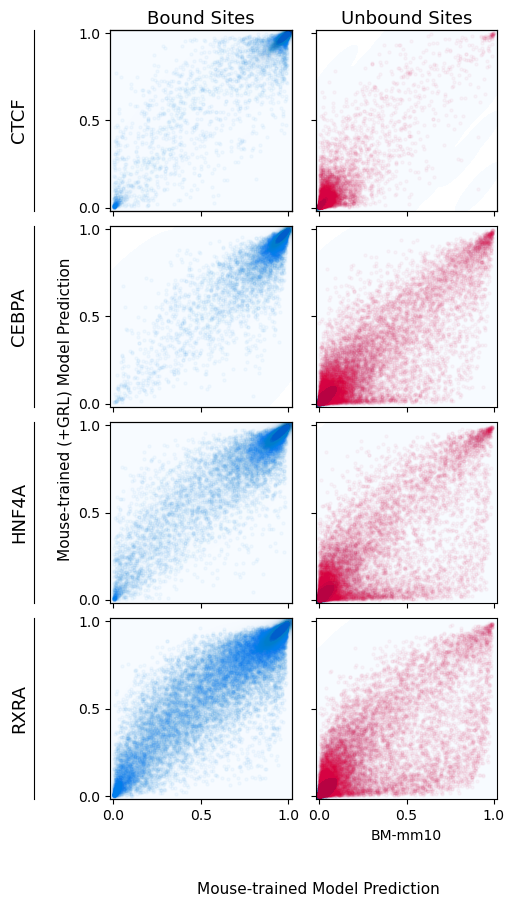

In [39]:
generate_bound_unbound_contours(preds_dfs, model_1_name="BM-mm10", model_2_name="GRL-mm10", save_files=True)

## Unbound Alu Scatters

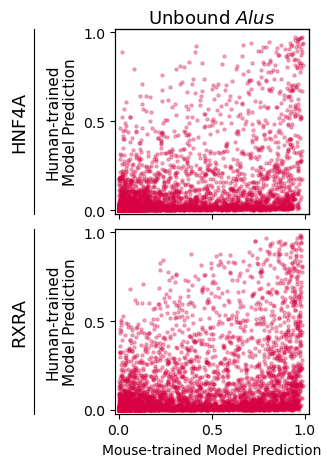

In [13]:
generate_unbound_alu_scatters(
    preds_and_labels_dfs,
    train_species = ["mm10", "hg38"],
    tf_split_half = 2,
    save_files=SAVE
)

-----